In [1]:
!pip install transformers
!pip install datasets
!pip install accelerator
!pip install farm-haystack[colab,preprocessing,elasticsearch,inference,metrics]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
%env TOKENIZERS_PARALLEISM=false

env: TOKENIZERS_PARALLEISM=false


In [2]:
# Suppress Haystack logging

import logging

for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

In [3]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [4]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

In [5]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [6]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [7]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(2, random_state=2)
sample_df

,title,question,answers.text,answers.answer_start,context
744,B0052YFYFK,How is the quality?,"[they can't get good quality audio, quality of...","[402, 49]",After reading so many reviews praising the aud...
981,B0078LSTWU,Where can I get a room without sound?,[],[],I bought this TV because of the Samsung name b...


In [8]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx: end_idx]

"they can't get good quality audio"

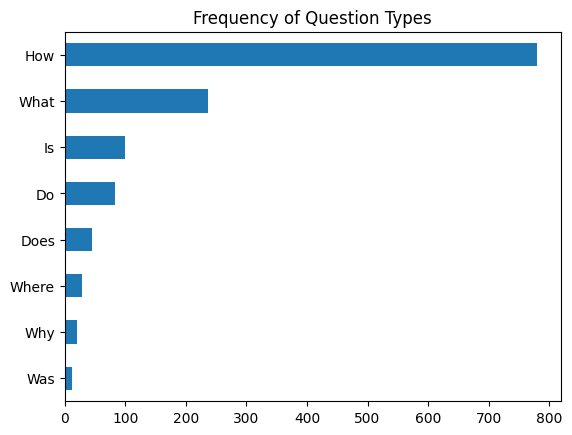

In [9]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [10]:
for question_type in ["How", "What", "Is"]:
    for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)]
                     .sample(n=3, random_state=2)["question"]):
        print(question)


How are display?
How do you rate the video?
How is the function?
What do you think about detail?
What kind battery life does this unit have?
What happens to the ports if you plug it in?
Is this how zoom works?
Is there a product?
Is this camera lightweight?


### Extracting Answer from Text

#### Like Span classification model

#### Tokenizing text for QA

In [11]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
question = "How much music can this hold?"
context = """
An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size.
"""
inputs = tokenizer(question, context, return_tensors="pt")


In [13]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [14]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [15]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [16]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [17]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


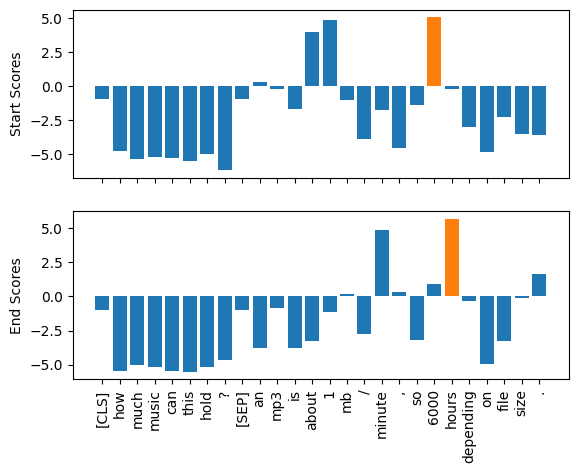

In [18]:
# The ide for this visualization comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

colors = ["C0" if s!=np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")

colors = ["C0" if e!=np.max(e_scores) else "C1" for e in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")

plt.xticks(rotation="vertical")
plt.show()

In [19]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [20]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651607394218445, 'start': 39, 'end': 49, 'answer': '6000 hours'},
 {'score': 0.2208300530910492,
  'start': 17,
  'end': 49,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253580659627914,
  'start': 17,
  'end': 28,
  'answer': '1 MB/minute'}]

In [21]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

### Dealing with long passages

In [22]:
dfs["train"]

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,[],[],[],[],[]
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as exp...","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]"
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True]
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,My sister's Bose headphones finally died and s...,How is the audio bass?,[the best of all of them],[1609],[1],[0.3],[False]
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy ob...,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with s...","[141, 38]","[1, 1]","[0.40833333, 0.40833333]","[False, False]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,electronics,great,impression,rubbery,feel,d4409d6272a7d1d5aa287d6e164bb7d0,1,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,e0ea72e711324b5482ec1b36a48f16ee,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610K...,Where can I feel my device?,[],[],[],[],[]
1291,electronics,tight,case,great,protection,ed6533390fe2fe0d546b69dea570c34b,5,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,ee5906ed3306b7c6d219a40adae2c7c2,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610K...,How does the selector protection me?,[],[],[],[],[]
1292,electronics,good,texture,good,grip,22b23446daf9d5bc0140be7278b220ee,1,0.00,False,84efbd9643d7f43af0ea0d2468c7dcc9,a541ffd9697ebf0ad9d226428594128e,B00HNGB1YS,"After using this case for a few days, I have g...",How is the grip?,[],[],[],[],[]
1293,electronics,easy to use,keyboard,removable,keyboard,e7967ad5be0658b4acfca1118f6af1ab,1,0.00,False,e856d7e5351e3385b5d75f06562e905b,7efc5e7ffaa79f53cc50f76a44f9f88e,B00HPM1G8Q,Edit 4/21/14. I finally caved and purchased a ...,How is the keyboard?,"[the keyboard is very easy to use, the keyboar...","[258, 258]","[1, 1]","[1.0, 1.0]","[True, True]"


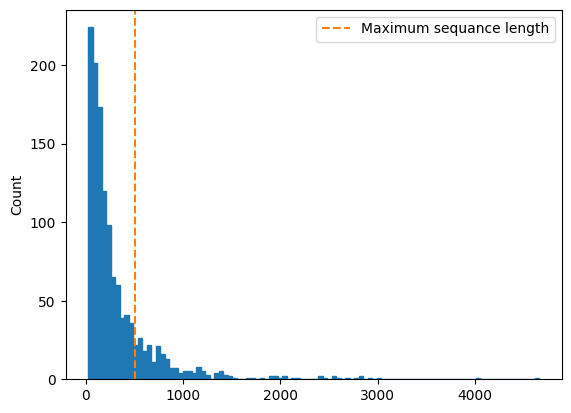

In [23]:
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", label="Maximum sequance length")
plt.legend()
plt.ylabel("Count")
plt.show()

### Windowing the context with stride

In [24]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [25]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [26]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



### Using Haystack to build a QA Pipeline

### Initalizing a document stor

In [27]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [28]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=["elasticsearch-7.9.2/bin/elasticsearch"],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))

# wait until Elasticseatch has started
!sleep 30

In [29]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "2f625f7caa4f",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "0bhT92YBRR-yfz7CRDhWMQ",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [30]:
# # Alternative if Docker is installed
# from haystack.utils import launch_es

# launch_es()

In [31]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriver
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [32]:
# It's a good idea to flush  Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("documents")
    document_store.delete_documents("label")



In [33]:
for split, df in dfs.items():
    # Exclude duplicate review
    docs = [{"content": row["context"],
             "meta": {"item_id": row["title"], "question_id": row["id"],
                      "split": split}}
            for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


### Initalizing a retriver

In [34]:
from haystack.nodes import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [35]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(query=query, top_k=3, filters={"item_id": [item_id],
                                                                      "split":["train"]})

In [36]:
print(retrieved_docs[0])

<Document: id=252e83e25d52df7311d597dc89eef9f6, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never ...'>


### Initializing a reader

In [37]:
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=True,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
print(reader.predict_on_texts(question, texts=[context], top_k=1))

Inferencing Samples: 100%|██████████| 1/1 [00:01<00:00,  1.49s/ Batches]

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648088693618774, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293056964874268, 'context': '\nAn MP3 is about 1 MB/minute, so about 6000 hours depending on file size.\n', 'offsets_in_document': [{'start': 39, 'end': 49}], 'offsets_in_context': [{'start': 39, 'end': 49}], 'document_ids': ['257f10546f78815ac5e83ff2fe0b996d'], 'meta': {}}>]}


### Putting it all togather

In [39]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, bm25_retriever)

In [40]:
n_answers = 3

params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 1}}
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3}, "Reader": {"top_k": n_answers}, "filters": {"item_id":[item_id], "split":["train"]}})

print(f"\nQuestion: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet ...{preds['answers'][idx].context}...")
    print("\n\n")

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  9.35 Batches/s]


Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet ...None...





### Improving our QA Pipeline

#### Evaluating the Retrivever

##### Each node in the Pipeline graph represents a class that takes some inputs and produces some outputs via a run() method

In [41]:
class PipelineNode:
    def __init__(self):
        self.outgoing_edges=1

    def run(self, **kwargs):
        return (outputs, "outgoing_edge_name")

### Deprecated since 2021

In [42]:
# from haystack.pipelines import Pipeline
# from haystack.eval import EvalDocuments


# class EvalRetrieverPipeline:
#     def __init__(self, retriever):
#         self.retriever = retriever
#         self.eval_retriever = EvalDocuments()
#         pipe = Pipeline()
#         pipe.add_node(component=self.retriever, name="ESRetriever", inputs=["Query"])
#         pipe.add_node(component=self.eval_retriever, name="EvalRetriever", inputs=["ESRetriever"])
#         self.pipeline = pipe

# pipe = EvalRetrieverPipeline(bm25_retriever)

### New Apporach

In [43]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [44]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}

    # Populate Labels for qustions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"],
                answer=Answer(answer=answer),
                origin="gold-label",
                document=Document(content=row["context"], id=row["review_id"]),
                meta=meta,
                is_correct_answer=True,
                is_correct_document=True,
                no_answer=False,
                filters={"item_id": [meta["item_id"]], "split":["test"]})

            labels.append(label)

    # Popualate labels for questions without answers
    else:
        label = Label(
            query=row["question"],
            answer=Answer(answer=""),
            origin="gold-label",
            document=Document(content=row["context"], id=row['review_id']),
            meta=meta,
            is_correct_answer=True,
            is_correct_document=True,
            no_answer=True,
            filters={"item_id": [row["title"]], "split": ["test"]})

        labels.append(label)

In [45]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 455 question-answer pairs


In [46]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"])

print(len(labels_agg))

330


In [47]:
# We can run the pipeline with the desired top_k value like this

eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k":3}})

metrics = eval_result.calculate_metrics()

In [48]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.95


In [49]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query",
                                                          "filters",
                                                          "rank",
                                                          "context",
                                                          "gold_contexts",
                                                          "document_id",
                                                          "gold_document_ids",
                                                          "gold_id_match"]]

,query,filters,rank,context,gold_contexts,document_id,gold_document_ids,gold_id_match
3,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",1.0,I bought this lens for my Canon 20D digital ca...,[I bought this lens for my Canon 20D digital c...,3566c491f5aafe80a22667754727dfc0,[fac2e8bec06035a70307dd1e8034ea63],0.0
4,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",2.0,I am not a professional or expert photographer...,[I bought this lens for my Canon 20D digital c...,d5c7736727a38c2fe62df10beef4a5ce,[fac2e8bec06035a70307dd1e8034ea63],0.0
8,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",1.0,I think that the title says it all. It is one ...,[],ebfb4b46819be7c051b27f0c28efd0fb,[],0.0
9,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",2.0,I bough this lens for a relative who bought my...,[],94163306f4c5c35c83ed165b2282cd32,[],0.0
10,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",3.0,I fell in love with the lens the moment I star...,[],7f5d77178fe93006124f731249d245f8,[],0.0
133,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'",1.0,I have read a lot of negative press about this...,[I have read a lot of negative press about thi...,11818a689fbac56cbb063eb658b22c05,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62c...",0.0


In [50]:
def evaluate_retriever(retriever, topk_values=[1,3,5,10,20]):
    topk_results = {}

    # Calculate max top_k
    max_top_k = max(topk_values)

    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)

    # Run inference with max top_k by Looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}})

    # Calculate metric for each top_k value
    for topk in topk_values:
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")

In [51]:
bm25_topk_df = evaluate_retriever(bm25_retriever)
bm25_topk_df

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

,recall
1,0.890909
3,0.954545
5,0.981818
10,0.990909
20,0.990909


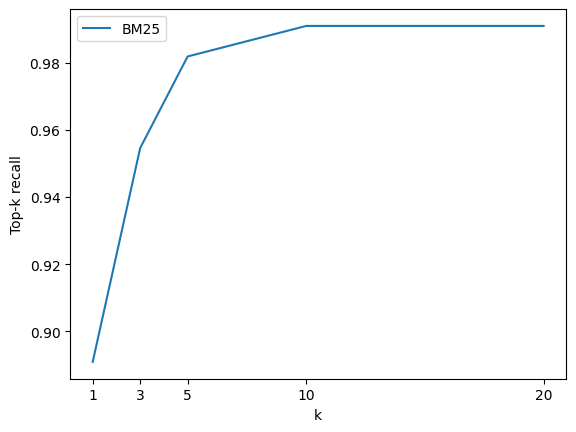

In [52]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)

    plt.xticks(df.index)
    plt.ylabel("Top-k recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

### Dense Passage Retrievel
#### Work with 2 bert encoders, 1 for question and second for passge, the pass the embedding vector to dot product similarity to map the patter similarity for each question with close answer

In [53]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
                                      query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
                                      passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
                                      embed_title=False) # Title here is not important because we work with product id

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [54]:
document_store.update_embeddings(retriever=dpr_retriever)

Create embeddings: 100%|██████████| 1616/1616 [00:22<00:00, 73.74 Docs/s]
Updating embeddings: 10000 Docs [00:39, 250.80 Docs/s]


In [55]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
dpr_topk_df

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

,recall
1,0.833333
3,0.957576
5,0.981818
10,0.993939
20,0.993939


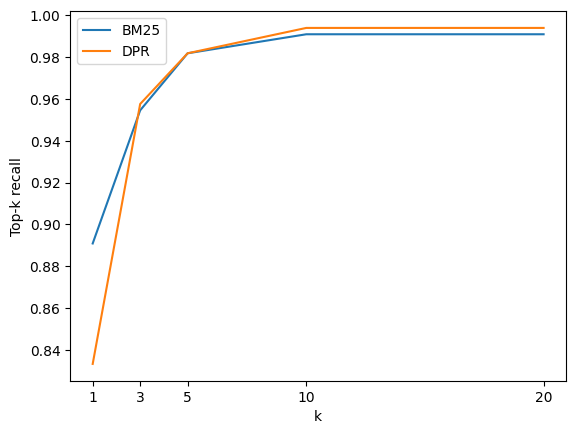

In [56]:
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

### Evaluate the Reader

In [57]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

label = "6000 hours"
pred = "about 6000 hours"
print(f"EM : {compute_exact(label, pred)}")
print(f"F1 : {compute_f1(label, pred)}")

EM : 0
F1 : 0.8


In [58]:
pred = "about 6000 dollars"
print(f"EM : {compute_exact(label, pred)}")
print(f"F1 : {compute_f1(label, pred)}")

EM : 0
F1 : 0.4


In [59]:
# # Deprecated

# from haystack.pipelines import Pipeline
# from haystack.eval import EvalAnswers

# def evaluate_reader(reader):
#     score_keys = ["exact_match", "f1"]
#     eval_reader = EvalAnswers(skip_incorrect_retrievel=False)
#     pipe = Pipeline()
#     pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
#     pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

#     for l in labels_agg:
#         doc = document_store.query(l.question,
#                                    filters={"question_id": [l.origin]})
#         _ = pipe.run(query=l.question, documents=doc, labels=l)

#     return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

In [60]:
from haystack.pipelines import Pipeline

def evaluate_reader(reader):
    score_keys = ["exact_match", "f1"]

    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents=[[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={})

    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k: v for k,v in metrics["Reader"].items() if k in score_keys}

In [61]:
reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)
reader_eval

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 46.39 Batches/s]


{'Fine-tune on SQuAD': {'exact_match': 0.4636363636363636,
  'f1': 0.5164710843721538}}

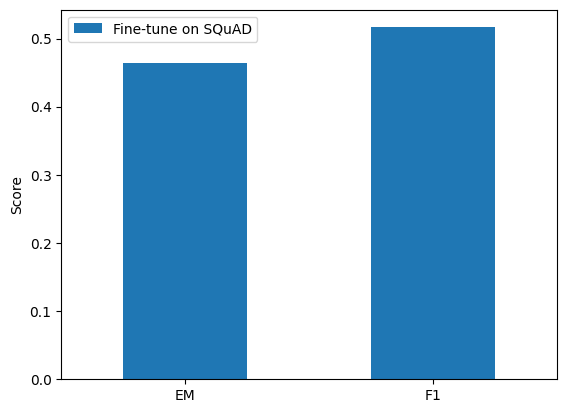

In [62]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc="upper left")
    plt.show()

plot_reader_eval(reader_eval)

### Domain Adaption

To match SubjQA to SQuAD json input format that's come in array of paragraphs for specific subject like:- <br>
Electornics title camer, tablet, ..." <br>
and array of question then array of answers with some meta data

In [63]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))

    for review_id, review in id2context.items():
        qas = []

        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))

        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_text = question_df["answers.text"][0].tolist()
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()

            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True

            # Add question-answer pairs to qas
            qas.append({"question": question,
                        "id": qid,
                        "is_impossible": is_impossible,
                        "answers": answers})

        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})

    return paragraphs

In [64]:
products = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(products)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [65]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}

        # Create 'paragraphs' for each product ID
        groups = (df.groupby("title").apply(create_paragraphs).to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")

        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

In [66]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir='.', use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

In [67]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 38.52 Batches/s]


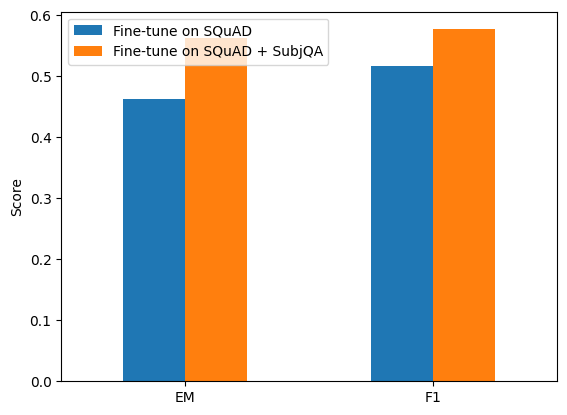

In [68]:
plot_reader_eval(reader_eval)

In [69]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [70]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
                    train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

In [71]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

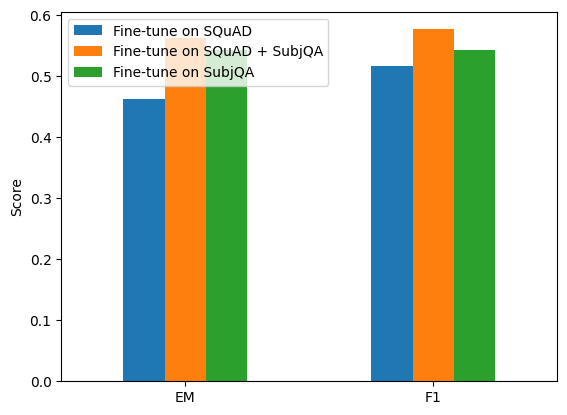

In [72]:
plot_reader_eval(reader_eval)

### Evaluating the Whole QA Pipeline

In [73]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# Evaluate!
eval_result = pipe.eval(labels=labels_agg, params={})

metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k, v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]
}

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 66.43 Batches/s]


In [74]:
reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.4636363636363636,
  'f1': 0.5164710843721538},
 'Fine-tune on SQuAD + SubjQA': {'exact_match': 0.5636363636363636,
  'f1': 0.5771952378650943},
 'Fine-tune on SubjQA': {'exact_match': 0.5424242424242425,
  'f1': 0.5424242424242425},
 'QA Pipeline (top-1)': {'exact_match': 0.5363636363636364,
  'f1': 0.5603149632575469}}

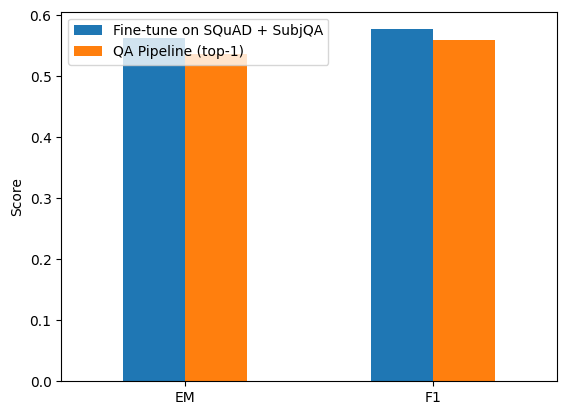

In [75]:
# id reader-vs-pipeline
# caption comparison of EM and _F_~1~ scores for the reader aganist the whole QA pipeline
plot_reader_eval({"Fine-tune on SQuAD + SubjQA": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA Pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 50.77 Batches/s]


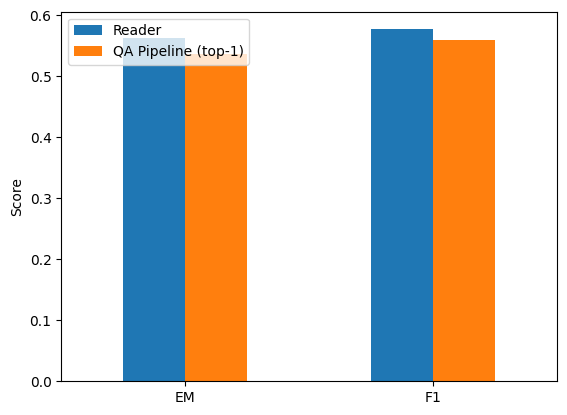

In [76]:
# Or get QA pipeline and reader metrics in one shot
# Reader evaluation is run on a second time using simulated perfect retriever results

eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)

metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

# Extract metrics from reader run in isolation with simulated perfect retriever
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1,
                                                 eval_mode="isolated")

pipeline_reader_eval={}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k, v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

### Going Beynod Extractive QA

In [78]:
!pip install farm-haystack[faiss]==1.17.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 94.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of azure-core to determine which version is compatible with other requireme

In [4]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=["elasticsearch-7.9.2/bin/elasticsearch"],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))

# wait until Elasticseatch has started
!sleep 30

In [5]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "2f625f7caa4f",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "0bhT92YBRR-yfz7CRDhWMQ",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [8]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriver
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [9]:
query = "Is it good for reading?"


In [10]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
                                      query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
                                      passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
                                      embed_title=False) # Title here is not important because we work with product id

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
from haystack.nodes import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


(…)_encoder_tokenizer/tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

question_encoder_tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)ncoder_tokenizer/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


(…)enerator_tokenizer/tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

generator_tokenizer/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

generator_tokenizer/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)erator_tokenizer/special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


pytorch_model.bin:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/rag-token-nq were not used when initializing RagTokenForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.weight', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.bias']
- This IS expected if you are initializing RagTokenForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagTokenForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
from haystack.pipelines import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [13]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query,
                     params={"Retriever": {"top_k": 5,
                                           "filters": {"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})

    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx].answer}")

In [14]:
generate_answers(query)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:2831: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


Question: Is it good for reading? 

Answer 1:  Kindle fire
Answer 2:  the Kindle fire
Answer 3:  e-reader


/usr/local/lib/python3.10/dist-packages/transformers/generation/logits_process.py:660: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  torch.sparse.LongTensor(banned_mask.t(), indices, scores.size())


In [15]:
generate_answers("What is the main drawback?")

Question: What is the main drawback? 

Answer 1:  the price
Answer 2:  the cost
Answer 3:  the power cord connection


### The QA hierarchy <br>

#### 1- search (TF-IDF, BM25, DPR) <br>
#### 2- Extraction (Zero-shot NER, domain adaption) <br>
#### 3- Generation (T5, RAG, GPT-3)